In [1]:
# Plot style
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Latin Modern"
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.direction"] = "in" 
plt.rcParams["ytick.direction"] = "in" 
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.right"] = True 
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["ytick.major.size"] = 3

In [ ]:
import json
import pandas as pd

with open("../../data/amega/syntactic/syntactic_perturbation_cases.json") as file:
    data = json.load(file)

mmlu_data_df = pd.DataFrame(data["data"])

In [3]:
def n_total_sentences_mmlu(row):
    n_question_sentences = len(row["question_metadata"]["original_sentences"])
    n_choices_sentences = sum(len(choice["original_sentences"]) for choice in row["choices_metadata"])
    return n_question_sentences + n_choices_sentences

def n_changed_sentences_mmlu(row):
    n_changed_sentences = 0
    for transformation in row["question_metadata"]["transformations"]:
        if transformation != "":
            n_changed_sentences += 1
    for choice in row["choices_metadata"]:
        for transformation in choice["transformations"]:
            if transformation != "":
                n_changed_sentences += 1

    return n_changed_sentences

def n_total_sentences_squad(row):
    n_question_sentences = len(row["question_metadata"]["original_sentences"])
    n_context_sentences = len(row["context_metadata"]["original_sentences"])
    return n_question_sentences + n_context_sentences

def n_changed_sentences_squad(row):
    n_changed_sentences = 0
    for transformation in row["question_metadata"]["transformations"]:
        if transformation != "":
            n_changed_sentences += 1
    for transformation in row["context_metadata"]["transformations"]:
        if transformation != "":
            n_changed_sentences += 1
    return n_changed_sentences

def n_total_sentences_amega(row, cases_df):
    n_sentences_question = len(row["metadata"]["original_sentences"])
    case_metadata = cases_df.loc[cases_df["case_id"] == row["case_id"], "metadata"].values[0]
    n_sentences_context = len(case_metadata["original_sentences"])
    return n_sentences_question + n_sentences_context

def n_changed_sentences_amega(row, cases_df):
    n_changed_sentences = 0
    for transformation in row["metadata"]["transformations"]:
        if transformation != "":
            n_changed_sentences += 1
    
    case_metadata = cases_df.loc[cases_df["case_id"] == row["case_id"], "metadata"].values[0]
    for transformation in case_metadata["transformations"]:
        if transformation != "":
            n_changed_sentences += 1
    
    return n_changed_sentences
    
def amega_per_question_total_score(row, criteria_df):
    criteria = criteria_df.loc[(criteria_df["case_id"] == row["case_id"]) & (criteria_df["question_id"] == row["question_id"])]
    return criteria["criteria_score_possible"].sum()

def amega_per_question_achieved_score(row, criteria_df, majority_vote_column):
    criteria = criteria_df.loc[(criteria_df["case_id"] == row["case_id"]) & (criteria_df["question_id"] == row["question_id"])]
    criteria_achieved = criteria[row[majority_vote_column]]
    return criteria_achieved["criteria_score_possible"].sum()

In [4]:
from haystack.components.evaluators import SASEvaluator
from haystack.utils import ComponentDevice
import evaluate

# Initialize evaluators
squad_evaluator = evaluate.load("squad")
sas_evaluator = SASEvaluator(device=ComponentDevice.from_str("mps"))
sas_evaluator.warm_up()


def exact_match_score(row, pred_column):
    result = squad_evaluator.compute(
        predictions=[{"id": "id", "prediction_text": row[pred_column]}],
        references=[{"id": "id", "answers": row["answers"]}]
    )["exact_match"]
    if int(result) == 100:
        return 1
    return 0

def f1_score(row, pred_column):
    result = squad_evaluator.compute(
        predictions=[{"id": "id", "prediction_text": row[pred_column]}],
        references=[{"id": "id", "answers": row["answers"]}]
    )["f1"]
    return result

def sas_score(row, pred_column):
    sas_eval = sas_evaluator.run(row["answers"]["text"], [row[pred_column]] * len(row["answers"]["text"]))
    return max(sas_eval["individual_scores"])

# Data Preprocessing
## MMLU

In [ ]:
import json
import pandas as pd

with open("../../data/mmlu/syntactic/syntactic_perturbation.json") as file:
    data = json.load(file)

mmlu_data_df = pd.DataFrame(data["data"])
mmlu_data_df["n_total_sentences"] = mmlu_data_df.apply(n_total_sentences_mmlu, axis=1)
mmlu_data_df["n_changed_sentences"] = mmlu_data_df.apply(n_changed_sentences_mmlu, axis=1)
mmlu_data_df["fraction_changed_sentences"] = mmlu_data_df["n_changed_sentences"] / mmlu_data_df["n_total_sentences"]

with open("../../results/gemma-3-12b/mmlu/original.json") as file:
    mmlu_original_performance_df = pd.DataFrame(json.load(file)["predictions"])
with open("../../results/gemma-3-12b/mmlu/syntactic/syntactic.json") as file:
    mmlu_synonym_performance_df = pd.DataFrame(json.load(file)["predictions"])

mmlu_data_df["correct_original"] = mmlu_original_performance_df["answer"] == mmlu_original_performance_df["prediction"]
mmlu_data_df["correct_synonym"] = mmlu_synonym_performance_df["answer"] == mmlu_synonym_performance_df["prediction"]

## SQuAD

In [ ]:
from datasets import load_dataset

with open("../../data/squad/syntactic/syntactic_perturbation.json") as file:
    data = json.load(file)

squad_data_df = pd.DataFrame(data["data"])
squad_data_df["n_total_sentences"] = squad_data_df.apply(n_total_sentences_squad, axis=1)
squad_data_df["n_changed_sentences"] = squad_data_df.apply(n_changed_sentences_squad, axis=1)
squad_data_df["fraction_changed_sentences"] = squad_data_df["n_changed_sentences"] / squad_data_df["n_total_sentences"]
squad_data_df["answers"] = load_dataset("rajpurkar/squad", split="validation").shuffle(seed=77).select(range(1000)).to_pandas()["answers"]

with open("../../results/gemma-3-12b/squad/original.json") as file:
    squad_original_performance_df = pd.DataFrame(json.load(file)["predictions"])
with open("../../results/gemma-3-12b/squad/lexical/llm_synonym.json") as file:
    squad_synonym_performance_df = pd.DataFrame(json.load(file)["predictions"])

squad_data_df["original_prediction"] = squad_original_performance_df["prediction"]
squad_data_df["synonym_prediction"] = squad_synonym_performance_df["prediction"]

squad_data_df["original_exact_match"] = squad_data_df.apply(exact_match_score, axis=1, pred_column="original_prediction")
squad_data_df["synonym_exact_match"] = squad_data_df.apply(exact_match_score, axis=1, pred_column="synonym_prediction")

squad_data_df["original_f1"] = squad_data_df.apply(f1_score, axis=1, pred_column="original_prediction")
squad_data_df["synonym_f1"] = squad_data_df.apply(f1_score, axis=1, pred_column="synonym_prediction")

squad_data_df["original_sas"] = squad_data_df.apply(sas_score, axis=1, pred_column="original_prediction")
squad_data_df["synonym_sas"] = squad_data_df.apply(sas_score, axis=1, pred_column="synonym_prediction")


## AMEGA

In [ ]:
with open("../../data/amega/syntactic/syntactic_perturbation_cases.json") as file:
    amega_cases_data_df = pd.DataFrame(json.load(file)["data"])

with open("../../data/amega/syntactic/syntactic_perturbation_questions.json") as file:
    amega_questions_data_df = pd.DataFrame(json.load(file)["data"])
criteria_df = pd.read_csv("../../AMEGA-benchmark/data/criteria.csv", sep=";")

amega_questions_data_df["n_changed_sentences"] = amega_questions_data_df.apply(n_changed_sentences_amega, axis=1, cases_df=amega_cases_data_df)
amega_questions_data_df["n_total_sentences"] = amega_questions_data_df.apply(n_total_sentences_amega, axis=1, cases_df=amega_cases_data_df)
amega_questions_data_df["fraction_changed_sentences"] = amega_questions_data_df["n_changed_sentences"] / amega_questions_data_df["n_total_sentences"]

with open("../../results/gemma-3-12b/amega/original.json") as file:
    amega_original_performance_df = pd.DataFrame(json.load(file)["predictions"])
with open("../../results/gemma-3-12b/amega/syntactic/syntactic.json") as file:
    amega_synonym_performance_df = pd.DataFrame(json.load(file)["predictions"])

amega_questions_data_df["majority_vote_original"] = amega_original_performance_df["majority_vote"]
amega_questions_data_df["majority_vote_synonym"] = amega_synonym_performance_df["majority_vote"]

amega_questions_data_df["total_score"] = amega_questions_data_df.apply(amega_per_question_total_score, axis=1, criteria_df=criteria_df)
amega_questions_data_df["achieved_score_original"] = amega_questions_data_df.apply(amega_per_question_achieved_score, axis=1, criteria_df=criteria_df, majority_vote_column="majority_vote_original")
amega_questions_data_df["achieved_score_synonym"] = amega_questions_data_df.apply(amega_per_question_achieved_score, axis=1, criteria_df=criteria_df, majority_vote_column="majority_vote_synonym")
amega_questions_data_df["performance_original"] = amega_questions_data_df["achieved_score_original"] / amega_questions_data_df["total_score"]
amega_questions_data_df["performance_synonym"] = amega_questions_data_df["achieved_score_synonym"] / amega_questions_data_df["total_score"]


# Performance difference by fraction of changed sentences

<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\%'


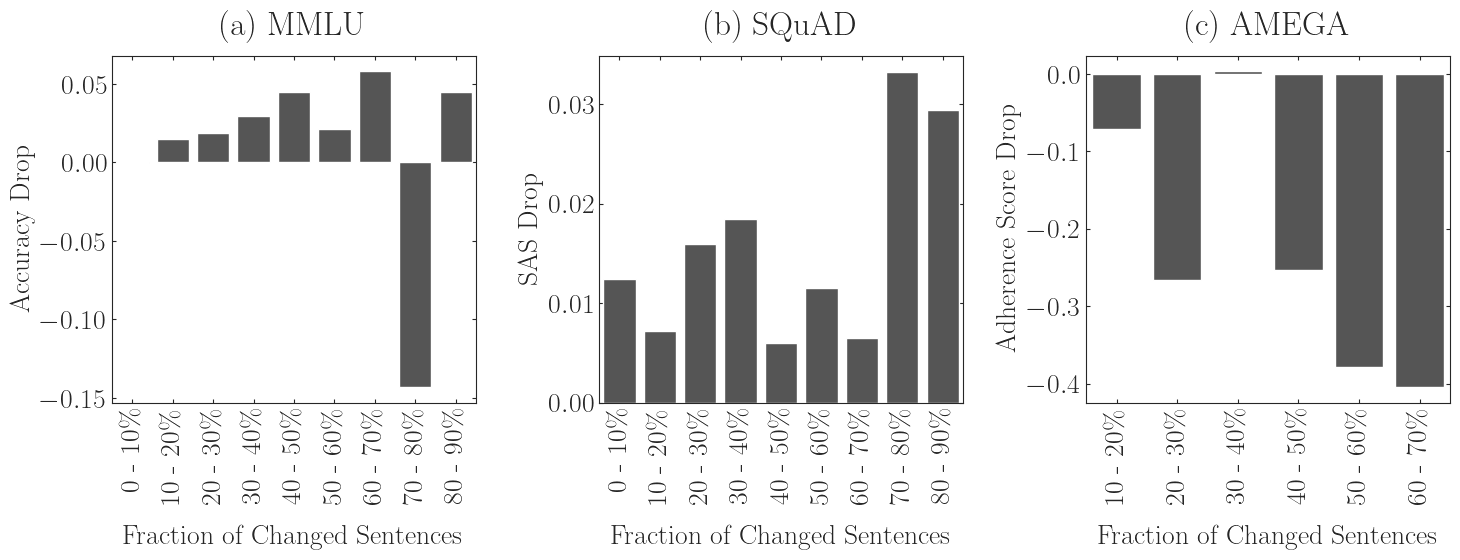

In [8]:
dfs = {
    "(a) MMLU": mmlu_data_df,
    "(b) SQuAD": squad_data_df,
    "(c) AMEGA": amega_questions_data_df
}

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ["0 - 10\%", "10 - 20\%", "20 - 30\%", "30 - 40\%", "40 - 50\%", "50 - 60\%", "60 - 70\%", "70 - 80\%", "80 - 90\%", "90 - 100\%"]

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for i, (label, df) in enumerate(dfs.items()):
    df["fraction_bin"] = pd.cut(
        df["fraction_changed_sentences"],
        bins=bins,
        labels=labels,
        right=False
    )
    bin_counts = df["fraction_bin"].value_counts().reindex(labels)

    if label == "(a) MMLU":
        performance_column_original = "correct_original"
        performance_column_synonym = "correct_synonym"
    elif label == "(b) SQuAD":
        performance_column_original = "original_sas"
        performance_column_synonym = "synonym_sas"
    elif label == "(c) AMEGA":
        performance_column_original = "achieved_score_original"
        performance_column_synonym = "achieved_score_synonym"

    bin_accuracy_original = df.groupby("fraction_bin")[performance_column_original].mean().reset_index()
    bin_accuracy_synonym = df.groupby("fraction_bin")[performance_column_synonym].mean().reset_index()

    bin_accuracy_original["performance_drop"] = bin_accuracy_original[performance_column_original] - bin_accuracy_synonym[performance_column_synonym]
    
    # Filter bins where bin_count > 10
    valid_bins = bin_counts[bin_counts > 10].index
    filtered_data = bin_accuracy_original[bin_accuracy_original["fraction_bin"].isin(valid_bins)]
    filtered_data["fraction_bin"] = filtered_data["fraction_bin"].cat.remove_unused_categories()
    
    sns.barplot(x="fraction_bin", y="performance_drop", data=filtered_data, color="#555555", ax=axes[i])
    
    axes[i].set_title(label, pad=15)
    axes[i].set_xlabel("Fraction of Changed Sentences", labelpad=15)
    if i == 0:
        axes[i].set_ylabel("Accuracy Drop")
    elif i == 1:
        axes[i].set_ylabel("SAS Drop")
    else:
        axes[i].set_ylabel("Adherence Score Drop")
    axes[i].set_xticks(range(len(filtered_data)))
    axes[i].set_xticklabels(filtered_data["fraction_bin"], rotation=90, ha="center")

plt.tight_layout()
plt.savefig("../../figs/syntactic_performance_drop.pdf", dpi=300)
plt.show()



In [9]:
n_total_sentences = lambda row: len(row["metadata"]["transformations"])
n_changed_sentences = lambda row: sum(1 for transformation in row["metadata"]["transformations"] if transformation != "")
amega_cases_data_df["n_total_sentences"] = amega_cases_data_df.apply(n_total_sentences, axis=1)
amega_cases_data_df["n_changed_sentences"] = amega_cases_data_df.apply(n_changed_sentences, axis=1)
amega_cases_data_df["fraction_changed_sentences"] = amega_cases_data_df["n_changed_sentences"] / amega_cases_data_df["n_total_sentences"]
